In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from funciones import *

# modelos
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Modelo red neuronal
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.regularizers import l2

import warnings
warnings.filterwarnings('ignore')

# Modelamiento

## Correlaciones y Reducción de variables

In [2]:
# Cargamos los datos procesados
df_procesado = pd.read_csv("data_procesada.csv",index_col='match_num')

In [3]:
#Vemos la correlaciones más altas
obtener_pares_correlacionados(df_procesado)

,Variable 1,Variable 2,Correlación
0,wards_placed,total_wards_placed,0.987094
1,min10_cs,min15_cs,0.972507
2,total_wards_placed,wards_per_min,0.965841
3,jungle_minions,role_JUNGLE,0.962410
4,vision_score,vs_per_min,0.961935
5,wards_placed,wards_per_min,0.957297
6,min15_cs,CS_per_min,0.954471
7,vision_score,total_wards_placed,0.929699
8,min10_cs,CS_per_min,0.926261
9,CS_per_min,role_UTILITY,-0.914273


In [4]:
# Eliminamos las columnas que generan multicolinealidad
df_reducido = df_procesado.drop(columns = ['wards_placed',
                                    'control_wards_placed',
                                    'wards_killed',
                                    'total_wards_placed',
				                    'wards_per_min',
                                    'wards_placed',
                                    'vision_score', # Dejamos vision score per min 
                                    'min5_cs',
                                    'min10_cs', 
                                    'min15_cs', # Dejamos cs per min
                                    'min5_cs_diff',
                                    'min10_cs_diff', # Dejamos cs diff min 15
                                    'min5_gold_diff',
                                    'min10_gold_diff', # Dejamos gold diff min 15
                                    'min5_xp_diff',
                                    'min10_xp_diff', # Dejamos xp diff min 15
                                    'min5_gold',
                                    'min10_gold', # Dejamos gold min 15
                                    'kills',
                                    'deaths',
                                    'assists', # Solo usamos KDA
                                    'lane_minions',
                                    'jungle_minions',
                                    'champion' # Usamos el Win ratio del campeón
                                   ])

In [5]:
# Observamos las mayores correlaciones nuevamente y verificamos que no existe multicolinealidad
obtener_pares_correlacionados(df_reducido)

,Variable 1,Variable 2,Correlación
0,CS_per_min,role_UTILITY,-0.914273
1,vs_per_min,role_UTILITY,0.881995
2,CS_per_min,vs_per_min,-0.826091
3,min15_gold_diff,min15_xp_diff,0.714077


## Spliteo de datos

In [6]:
X = df_reducido.drop(columns = ['win']) 
y = df_reducido['win']

# Spliteamos
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.30, random_state=42)

## Escalamiento de los datos

In [7]:
# Estandarizamos los datos para que todos tengan la misma medida
# Lista de columnas a excluir: item_, role_, rune_, champ_
exclude_cols = ['champion',
                'is_MMR_check',
                'role_JUNGLE',
                'role_UTILITY',
                'role_MIDDLE',
                'role_TOP',
                'is_flex']

X_train_scaled, X_test_scaled  = scaler(X_train, X_test, exclude_cols)

Se escalaron las siguientes columnas: ['CS_per_min', 'KDA', 'game_duration', 'history_wr_champ', 'history_wr_global', 'min15_cs_diff', 'min15_gold', 'min15_gold_diff', 'min15_xp_diff', 'racha_previa', 'vs_per_min']


## Regresión logistica

In [8]:
model_log = LogisticRegression(random_state=42)
model_log.fit(X_train_scaled, y_train)
y_pred_log = model_log.predict(X_test_scaled)

### Matríz de confusión de la regresión logística

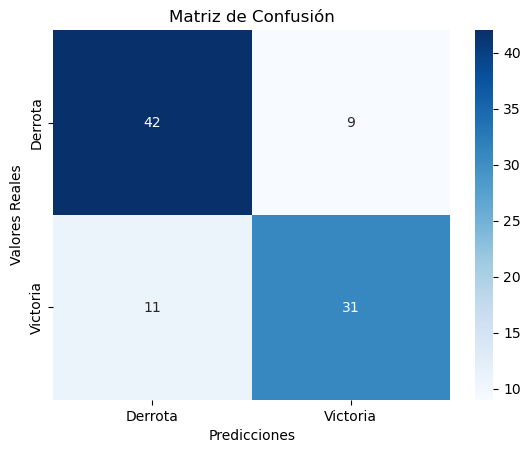


Reporte de Clasificación Regresión Logística:
              precision    recall  f1-score   support

           0       0.79      0.82      0.81        51
           1       0.78      0.74      0.76        42

    accuracy                           0.78        93
   macro avg       0.78      0.78      0.78        93
weighted avg       0.78      0.78      0.78        93



In [9]:
# Crear un heatmap de la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_log)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Derrota', 'Victoria'], yticklabels=['Derrota', 'Victoria'])
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión')
plt.show()

print("\nReporte de Clasificación Regresión Logística:")
print(classification_report(y_test, y_pred_log))

**Observaciones** 
- A pesar de existen algunos falsos positivos y verdaderos negativos, en general tenemos un rendimiento del modelo bastante bueno, dado que su accuracy general es del 0.78.
- El modelo detecta un poco mejor las derrotas (f1 score = 0.81) que las victorias (f1 score = 0.76).

### Curva ROC-AUC de la regresión logística

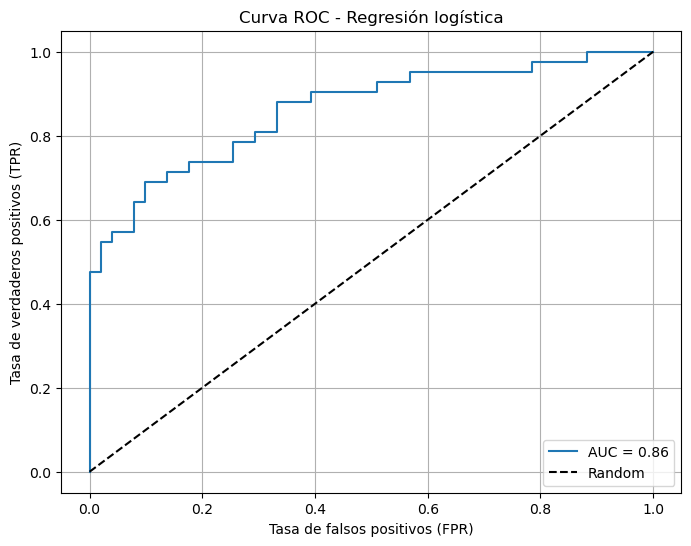

In [10]:
y_pred_prob = model_log.predict_proba(X_test_scaled)[:, 1]

# 2. Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# 3. Calcular AUC
auc_score = roc_auc_score(y_test, y_pred_prob)

# 4. Graficar
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0,1], [0,1], 'k--', label='Random')
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.title('Curva ROC - Regresión logística')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


**Observaciones** 
- El valor AUC es de 0.86 por lo que el modelo detecta bastante bien entre verdaderos positivos y falsos positivos.

## Support Vector Machine con ajuste de hiperparámetros

In [11]:
# Definir el modelo base
svm_model = SVC(random_state=42, max_iter=100000)

# Rango de parámetros a probar
param_grid_svm = {
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'C': [0.01, 0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.1, 1]
}

# Configurar búsqueda
grid_search_svm = GridSearchCV(svm_model, param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)

# Entrenar
grid_search_svm.fit(X_train_scaled, y_train)

# Mejor modelo
best_svm = grid_search_svm.best_estimator_
print("Mejores parámetros:", grid_search_svm.best_params_)

Mejores parámetros: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}


### Matríz de confusión de SVM

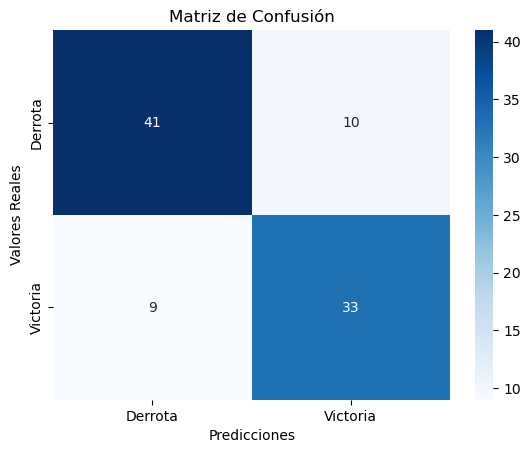


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81        51
           1       0.77      0.79      0.78        42

    accuracy                           0.80        93
   macro avg       0.79      0.79      0.79        93
weighted avg       0.80      0.80      0.80        93



In [12]:
y_pred_svm = best_svm.predict(X_test_scaled)

# Crear un heatmap de la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_svm)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Derrota', 'Victoria'], yticklabels=['Derrota', 'Victoria'])
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión')
plt.show()

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_svm))

**Observaciones** 
- Existen algunos falsos positivos y verdaderos negativos (menos que en regresíon logística), en general tenemos un rendimiento del modelo bastante un poco mejor que con regresión logística
- El modelo detecta un poco mejor las derrotas (f1 score = 0.81) que las victorias (f1 score = 0.78).

### Curva ROC-AUC de SVM

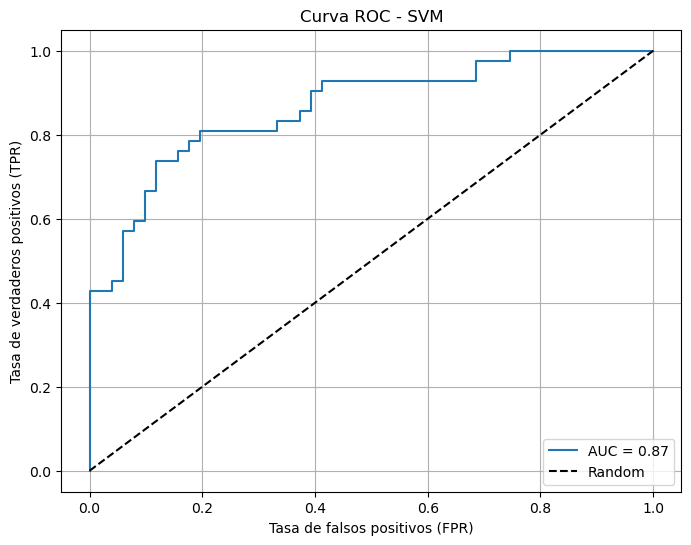

In [13]:
# Obtén los scores con decision_function
y_scores_svm = best_svm.decision_function(X_test_scaled)

# Calcula ROC y AUC usando estos scores
fpr, tpr, thresholds = roc_curve(y_test, y_scores_svm)
auc = roc_auc_score(y_test, y_scores_svm)

# 4. Graficar
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1], [0,1], 'k--', label='Random')
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.title('Curva ROC - SVM')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


**Observaciones** 
- El valor AUC es de 0.86 por lo que el modelo detecta bastante bien entre verdaderos positivos y falsos positivos.

## Decision Tree con ajuste de hiperparámetros

In [14]:
# 3. Definir el modelo base
dt_model = DecisionTreeClassifier()

# 4. Definir la grilla de hiperparámetros
param_grid_dt = {
    'max_depth': [None, 3, 5, 10],                 # profundidad máxima
    'min_samples_split': [2, 5, 10],               # mínimo para dividir nodo
    'min_samples_leaf': [1, 2, 4],                 # mínimo por hoja
}

# GridSearch con validación cruzada
grid_search_dt = GridSearchCV(dt_model, param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)

# Entrenar
grid_search_dt.fit(X_train_scaled, y_train)

# Mejor modelo
best_dt = grid_search_dt.best_estimator_
print("Mejores parámetros:", grid_search_dt.best_params_)

Mejores parámetros: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


### Matríz de confusión de Decision Tree

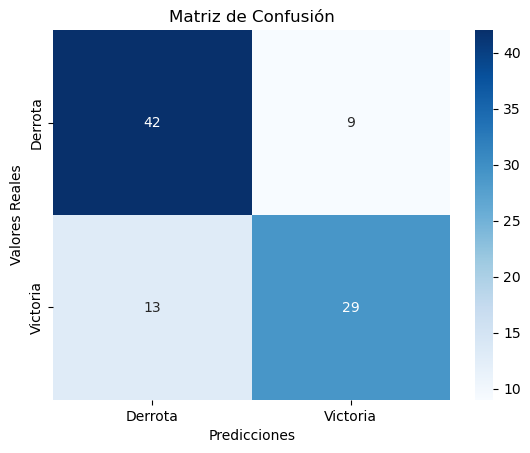


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.76      0.82      0.79        51
           1       0.76      0.69      0.72        42

    accuracy                           0.76        93
   macro avg       0.76      0.76      0.76        93
weighted avg       0.76      0.76      0.76        93



In [15]:
y_pred_dt = best_dt.predict(X_test_scaled)

# Crear un heatmap de la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_dt)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Derrota', 'Victoria'], yticklabels=['Derrota', 'Victoria'])
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión')
plt.show()

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_dt))

### Curva ROC-AUC de decition tree

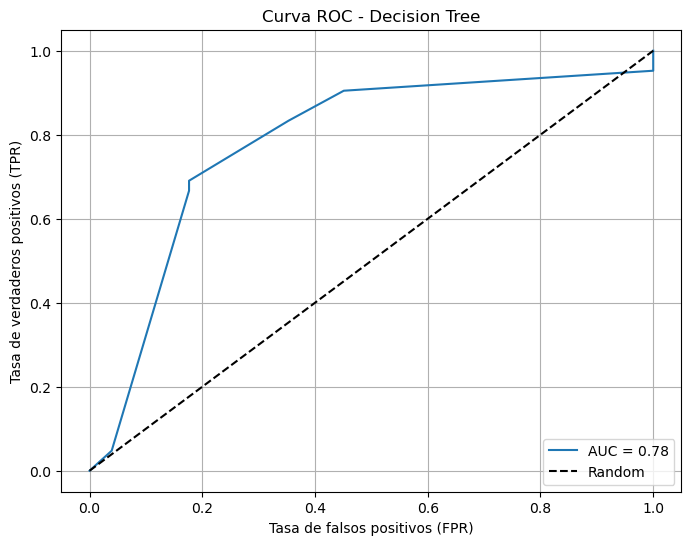

In [16]:
# Probabilidad de la clase positiva (1, por ejemplo "victoria")
y_probs_dt = best_dt.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs_dt)
auc = roc_auc_score(y_test, y_probs_dt)

# 4. Graficar
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1], [0,1], 'k--', label='Random')
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.title('Curva ROC - Decision Tree')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## Random Forest con ajuste de hiperparámetros

In [17]:
model_rf = RandomForestClassifier()

param_grid_rf = {
    'n_estimators': [10, 50, 100, 200],      # número de árboles
    'max_depth': [None, 3, 5, 10, 20, 30],   # profundidad máxima
    'min_samples_split': [2, 5, 10],         # mínimo para dividir nodo
    'min_samples_leaf': [1, 2, 4],           # mínimo por hoja
}

# GridSearch con validación cruzada
grid_search_rf = GridSearchCV(model_rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)

# Entrenar
grid_search_rf.fit(X_train_scaled, y_train)

# Mejor modelo
best_rf = grid_search_rf.best_estimator_
print("Mejores parámetros:", grid_search_rf.best_params_)

Mejores parámetros: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}


### Matríz de confusión de Random Forest

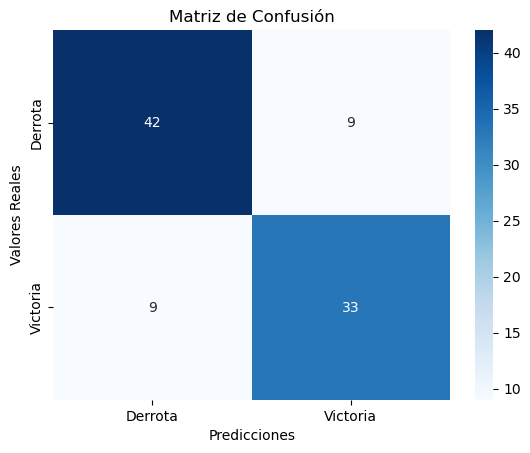


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        51
           1       0.79      0.79      0.79        42

    accuracy                           0.81        93
   macro avg       0.80      0.80      0.80        93
weighted avg       0.81      0.81      0.81        93



In [18]:
y_pred_rf = best_rf.predict(X_test_scaled)

# Crear un heatmap de la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Derrota', 'Victoria'], yticklabels=['Derrota', 'Victoria'])
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión')
plt.show()

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_rf))

### Curva ROC-AUC de Random Forest

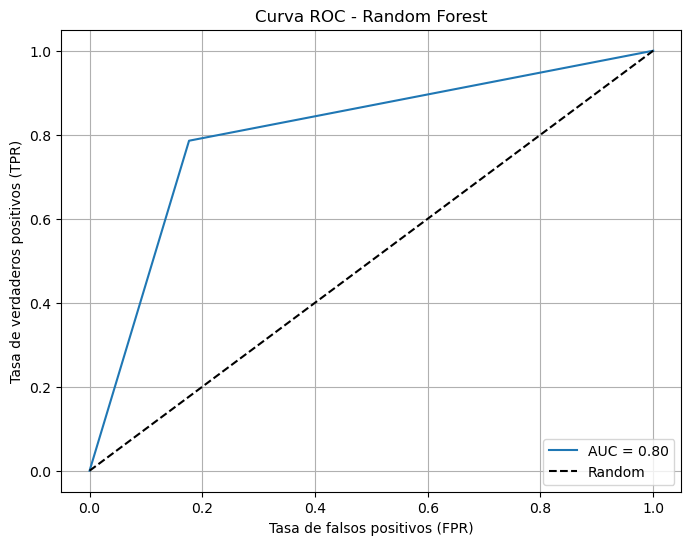

In [19]:
# Probabilidad de la clase positiva (1, por ejemplo "victoria")
y_probs_rf = best_rf.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf)
auc = roc_auc_score(y_test, y_pred_rf)

# 4. Graficar
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1], [0,1], 'k--', label='Random')
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.title('Curva ROC - Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## Red neuronal

In [20]:
# Crear modelo
model_mlp = Sequential([
    Dense(32, activation='relu', kernel_initializer=HeNormal(),
          kernel_regularizer=l2(0.001), use_bias=True,
          bias_initializer='zeros', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),

    Dense(16, activation='relu', kernel_initializer=HeNormal(),
          kernel_regularizer=l2(0.001), use_bias=True,
          bias_initializer='zeros'),
    Dropout(0.3),

    Dense(8, activation='relu', kernel_initializer=HeNormal(),
          kernel_regularizer=l2(0.001), use_bias=True,
          bias_initializer='zeros'),
    Dropout(0.3),

    Dense(1, activation='sigmoid')  # salida binaria
])

model_mlp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,249 (4.88 KB)

 Trainable params: 1,249 (4.88 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Compilar
model_mlp.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Entrenar
history = model_mlp.fit(X_train_scaled, y_train,
                    validation_data=(X_test_scaled, y_test),
                    epochs=50,
                    batch_size=32,
                    verbose=1)


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.4860 - loss: 1.0395 - val_accuracy: 0.5054 - val_loss: 0.8156
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5467 - loss: 0.9255 - val_accuracy: 0.5161 - val_loss: 0.8024
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5234 - loss: 0.9639 - val_accuracy: 0.5269 - val_loss: 0.7937
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4907 - loss: 0.9696 - val_accuracy: 0.5376 - val_loss: 0.7869
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5280 - loss: 0.8826 - val_accuracy: 0.5269 - val_loss: 0.7831
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5234 - loss: 0.8995 - val_accuracy: 0.5269 - val_loss: 0.7803
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5234 - loss: 0.8790 - val_accuracy: 0.5591 - val_loss: 0.7771
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5047 - loss: 0.8537 - val_accuracy: 0.5699 - val_loss: 0.7748


### Matríz de confusión de Red neuronal

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


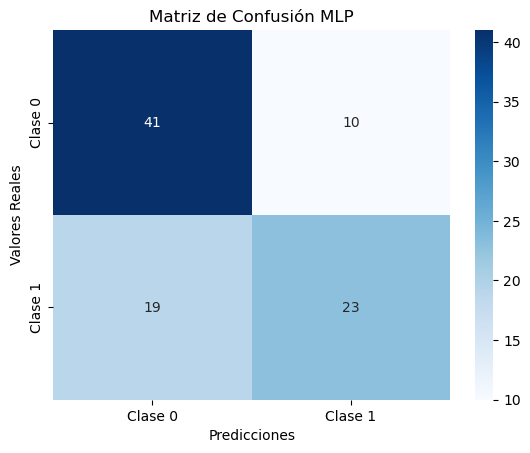


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.68      0.80      0.74        51
           1       0.70      0.55      0.61        42

    accuracy                           0.69        93
   macro avg       0.69      0.68      0.68        93
weighted avg       0.69      0.69      0.68        93



In [22]:
# 1️⃣ Predecir
y_pred_prob = model_mlp.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)  # convertir a 0/1

conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0','Clase 1'], yticklabels=['Clase 0','Clase 1'])
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión MLP')
plt.show()

# 3️⃣ Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

### Curva Roc-AUC con Red Neuronal 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


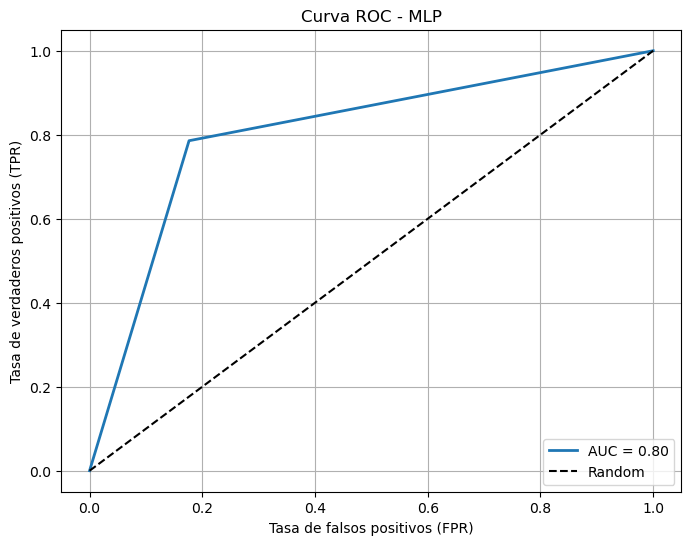

In [23]:
# Probabilidad de la clase positiva (1, por ejemplo "victoria")
y_probs_mlp = model_mlp.predict(X_test_scaled).ravel()  # ravel() para dejarlo 1D

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}', linewidth=2)
plt.plot([0,1], [0,1], 'k--', label='Random')
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.title('Curva ROC - MLP')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## XGB con ajuste de hiperparámetros

In [24]:

# 1. Crear el modelo XGB básico
model_xgb = xgb.XGBClassifier(random_state=42)

# 2. Definir la grilla de hiperparámetros
param_grid_xgb = {
    'n_estimators': [50, 100, 200, 300],          # cantidad de árboles
    'max_depth': [2, 3, 4, 5, 6],                 # profundidad máxima de cada árbol
    'learning_rate': [0.01, 0.05, 0.1, 0.2],     # velocidad de aprendizaje
    'subsample': [0.6, 0.8, 1.0],                 # proporción de datos para cada árbol
    'colsample_bytree': [0.6, 0.8, 1.0],          # proporción de features usadas en cada árbol
    'gamma': [0, 0.1, 0.2],                       # regularización para evitar sobreajuste
}

# 3. Configurar GridSearchCV
grid_search_xgb = GridSearchCV(estimator=model_xgb, param_grid=param_grid_xgb, scoring='accuracy', cv=5, n_jobs=-1)

# 4. Entrenar
grid_search_xgb.fit(X_train_scaled, y_train)

best_xgb = grid_search_xgb.best_estimator_
print("Mejores parámetros:", grid_search_xgb.best_params_)

Mejores parámetros: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 50, 'subsample': 0.6}


## Matríz de confusión de XGB con hiperparámetros

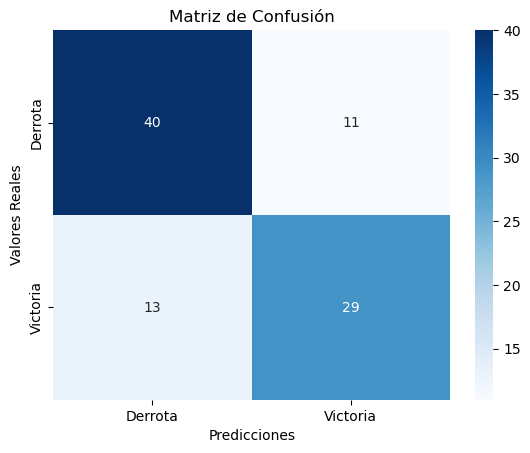


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.75      0.78      0.77        51
           1       0.72      0.69      0.71        42

    accuracy                           0.74        93
   macro avg       0.74      0.74      0.74        93
weighted avg       0.74      0.74      0.74        93



In [25]:
# 6. Predecir y evaluar

y_pred_xgb = best_xgb.predict(X_test_scaled)

# Crear un heatmap de la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_xgb)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Derrota', 'Victoria'], yticklabels=['Derrota', 'Victoria'])
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión')
plt.show()

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_xgb))

## Curva Roc-AUC con XGB con hiperparámetros

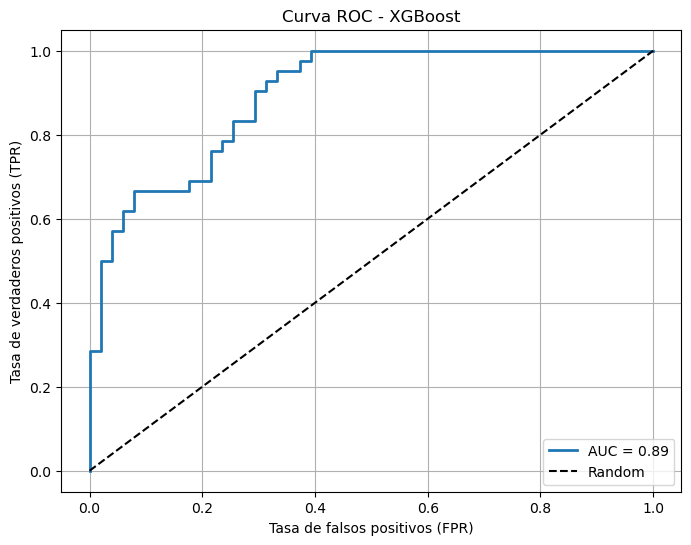

In [26]:
# 1️⃣ Obtener probabilidades de la clase positiva (1 = Victoria)
y_probs_xgb = best_xgb.predict_proba(X_test_scaled)[:, 1]  # tomar solo la columna de clase positiva

# 2️⃣ Calcular ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs_xgb)
auc = roc_auc_score(y_test, y_probs_xgb)

# 3️⃣ Graficar curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}', linewidth=2)
plt.plot([0,1], [0,1], 'k--', label='Random')
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.title('Curva ROC - XGBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Top 7 Variables más relevantes para el modelo

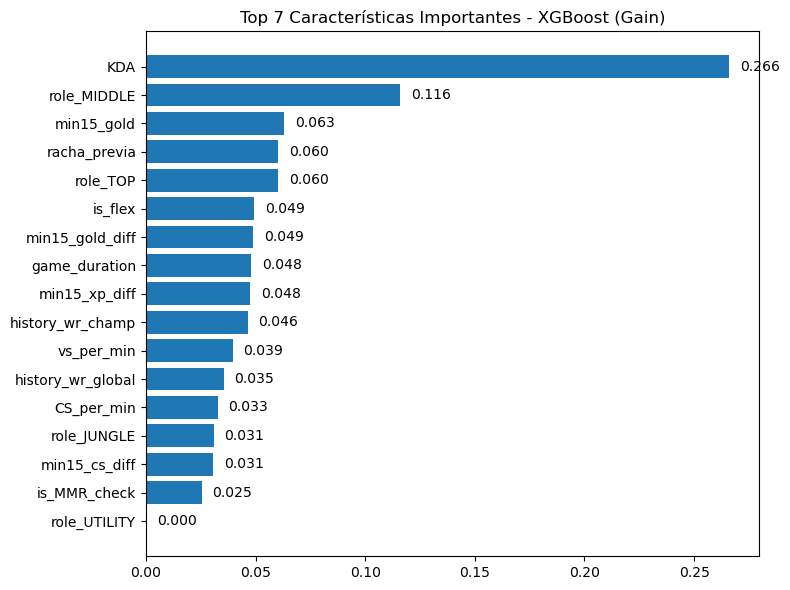

In [27]:
# Importancias del modelo XGBoost (gain por defecto)
importancias = best_xgb.feature_importances_

# Seleccionar el top 7
top_20_idx = np.argsort(importancias)[-20:][::-1]

# Obtener nombres de las features
nombres = X_train_scaled.columns[top_20_idx] if hasattr(X_train_scaled, 'columns') else [f'Feature_{i}' for i in top_20_idx]

# Gráfico con etiquetas numéricas
plt.figure(figsize=(8, 6))
bars = plt.barh(y=nombres, width=importancias[top_20_idx], color='#1f77b4')
plt.gca().invert_yaxis()  # Mayor importancia arriba
plt.title('Top 7 Características Importantes - XGBoost (Gain)')

# Agregar los valores numéricos a cada barra
for bar, value in zip(bars, importancias[top_20_idx]):
    plt.text(value + 0.005,               # un poquito a la derecha de la barra
             bar.get_y() + bar.get_height()/2, 
             f"{value:.3f}", va='center')

plt.tight_layout()
plt.show()


**Observaciones** 
Las variables que tienen un mayor porcentaje de incidencia en la predicción de victoria son:

- Destrucción de inhibidores.
- Derribo de torretas.
- Asesinato de dragones.

Las variables que tienen relación con las mecánicas del jugador (microgame) y tienen mayor impacto en la tasa de victorias:

- Daño recibido.
- Oro obtenido.
- KDA.
- Wards por minuto.
- Jugar thresh.
  
En estas variables es donde está el margen de mejora específico del jugador para obtener una tasa más alta de victorias.

**Análisis por variable con mayor relevancia**

- Destrucción de inhibidores, derribo de torretas y asesinato de dragones: Estas 3 variables son las predictoras más evidentes, dado que son objetivos principales (macrogame) y requerimientos para poder obtener una victoria. Cada una de las variables tiene prioridad en cada partida, tenerlas como objetivo principal es, en casi cualquier partida, un indicador de una victoria. 

- Daño recibido: Disminuir el daño recibido puede implicar una mejor toma de decisiones dentro de la partida. Tomar decisiones que tengan bajo riesgo y alto beneficio signfica, en este caso, que se logra perder menos vida en cada jugada planteada y ser más eficiente en dichas decisiones.

- Oro obtenido: Conectado con lo anterior, una mejor toma de decisiones genera una optimización del oro ganado, ya sea solo asesinando súbditos o peleas en equipo, una mejor toma de decisiones, disminuye el daño recibido y aumenta el oro obtenido.

- KDA: El KDA es producto de los puntos anteriores. Disminuir el daño recibido y aumentar el oro obtenido está directamente relacionado con la mejoría del KDA.

- Wards por minuto: Colocar más centinelas de visión brinda mayor información al jugador y a su equipo, dando mejores oportunidades para obtener oro.

- Jugar thresh: Jugar con el campeón Thresh, el jugador tiene una tasa de victoria más alta.


# Conclusiones

En base a los análisis realizados y los modelos creados, podemos determinar lo siguiente:

Si bien existen variables predictoras que mucho del jugador (roles favoritos, campeones favoritos, KDA), existen directrices generales que generan más vicotrias, la destrucción de inhibidores, el derribo de torretas y el asesinato de dragones. A pesar de ser "apreciaciones" muy lógicas - dado que si no se destruye torretas no puedes llegar al nexo enemigo y ganar las partidas -, es importante resaltar su importancia para generar una mejor toma de decisiones a nivel de macrogame.

Por otro lado, el rendimiento individual del jugador depende mucho de su estilo de juego (si juega campeones tanques, es muy probable que su daño recibido sea mucho más alto dado que es parte de la mecánica de ser el tanque), si hay aspectos generales de microjuego generales. Mantener un buen KDA, colocar centinelas, optimizar sus jugadas (disminuir riesgo y aumentar beneficios) y jugar los campeones y roles que tienen mayor porcentaje de victorias.